In [4]:
BTC_COIN_PRICE_HISTORY_FILE_PATH="C:\\Users\\adubey4558\\OneDrive - San Diego State University (SDSU.EDU)\Documents\\Sem2\\CS649\Final Project\\BitCoinTweetsIngestionAndSentimentAnalysis\\project\\datasets\\BTC-USD.csv"


from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
import pandas as pd
from MyConfig import *

Gets an existing SparkSession or, if there is no existing one, creates a new one based on the options set in this builder and loads the config for mongo-spark connector. <br/>
Master - Sets the Spark master URL to connect to, such as "local" to run locally, "local[4]" to run locally with 4 cores, or "spark://master:7077" to run on a Spark standalone cluster. 

Reading Bitcoin collection from MongoDB

In [2]:
spark = SparkSession \
    .builder \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.11:2.3.2') \
    .master("local[*]") \
    .getOrCreate()

df = spark.read.format("mongodb") \
    .option("spark.mongodb.connection.uri", "mongodb+srv://" + mongo_user_name + ":" + mongo_password + "@cluster0.nwuw7.mongodb.net") \
    .option("spark.mongodb.database", mongo_db) \
    .option("spark.mongodb.collection", mongo_bitcoin_collection) \
    .load()

df.show()

c:\Users\adubey4558\Anaconda3\envs\pyspark_env\lib\site-packages\pyspark\context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


+--------------------+------------------------+-------------------+--------------------+----------+-------------------+--------------------+-------------------+--------------------+---------------+--------------+------------+-------------------+--------------------+-------------+
|                 _id|compound_sentiment_score|               date|            hashtags|is_retweet|             source|                text|       user_created|    user_description|user_favourites|user_followers|user_friends|      user_location|           user_name|user_verified|
+--------------------+------------------------+-------------------+--------------------+----------+-------------------+--------------------+-------------------+--------------------+---------------+--------------+------------+-------------------+--------------------+-------------+
|627f421f285855028...|                    0.25|2021-02-07 02:14:33|                    |     False|         Integromat|just added 105. T...|2020-07-03 02:02:

Read Bitcoin price history, and enable it to clean the data further.

In [5]:
df_price = pd.read_csv(BTC_COIN_PRICE_HISTORY_FILE_PATH)
df_price.Date = pd.to_datetime(df_price.Date)
df_price.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200


Over-sampling, under-sampling and combination between both in order to balance an imbalanced training data-set for Twitter Sentimental Analysis

We will use this sentiment analysis of the tweets to calculate a score that will represent the importance of each tweet.

In [6]:
# sentiment analysis 
df_clean = df.toPandas().drop_duplicates()
tweets = df_clean.copy()
tweets['date'] = pd.to_datetime(tweets['date'],utc=True)
tweets.date = tweets.date.dt.tz_localize(None)
tweets.index = tweets['date']

tweets_grouped = tweets.resample('D').sum()

crypto_usd = df_price.copy()
crypto_usd['Date'] = pd.to_datetime(crypto_usd['Date'], unit='s')
crypto_usd.index = crypto_usd['Date']

crypto_usd_grouped = crypto_usd.resample('D')['Close'].mean()

Cross correlation - is used to compute pairwise correlation between rows or columns of two DataFrame objects. If the shape of two dataframe object is not same then the corresponding correlation value will be a NaN value.

In [7]:
def crosscorr(datax, datay, lag=0, method="pearson"):
    """ Lag-N cross correlation. 
    Parameters
    —------—
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    —------—
    crosscorr : float
    """
    return datax.corrwith(datay.shift(lag), method=method)['compound_sentiment_score']

In [8]:
beggining = max(tweets_grouped.index.min().replace(tzinfo=None), crypto_usd_grouped.index.min())
end = min(tweets_grouped.index.max().replace(tzinfo=None), crypto_usd_grouped.index.max())
tweets_grouped = tweets_grouped[beggining:end]
crypto_usd_grouped = crypto_usd_grouped[beggining:end]

Visualize Bitcoin Price influenced by twitter sentiment

c:\Users\adubey4558\Anaconda3\envs\pyspark_env\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


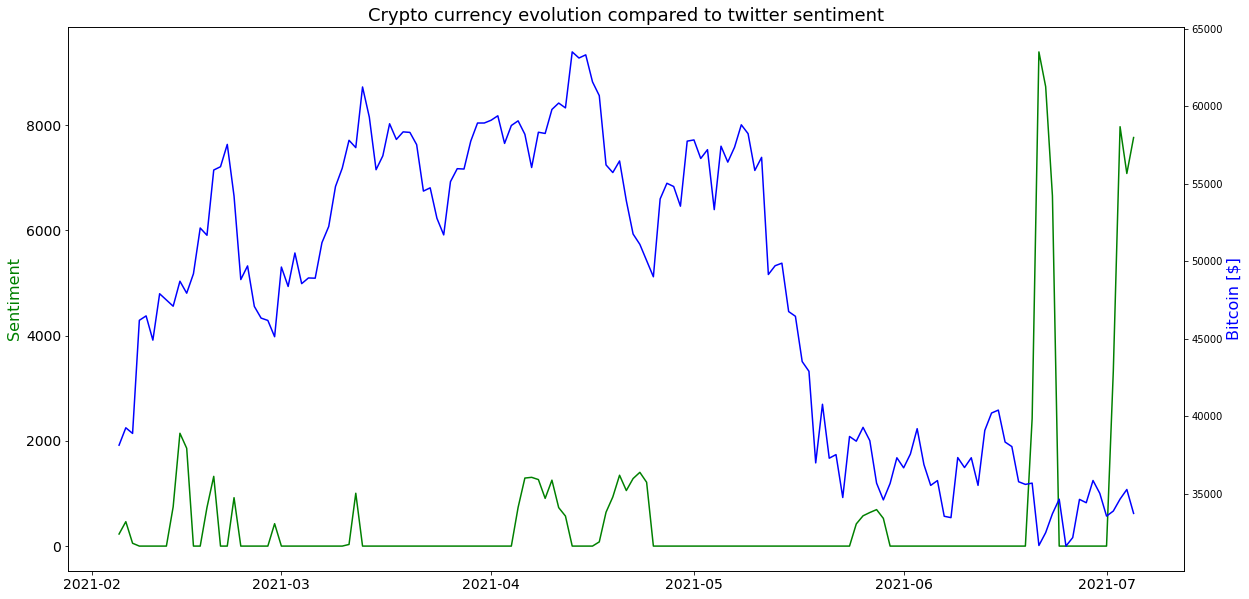

In [9]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Crypto currency evolution compared to twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel("Bitcoin [$]", color='b', fontsize=16)
plt.show()

Pearson cross-correlation - It is the ratio between the covariance[3] of two variables and the product of their standard deviations; thus it is essentially a normalized measurement of the covariance, such that the result always has a value between −1 and 1

Kendall's τ coefficient (after the Greek letter τ, tau), is a statistic used to measure the ordinal association between two measured quantities. A τ test is a non-parametric hypothesis test for statistical dependence based on the τ coefficient.

The Spearman correlation is less sensitive than the Pearson correlation to strong outliers that are in the tails of both samples. That is because Spearman's ρ limits the outlier to the value of its rank.

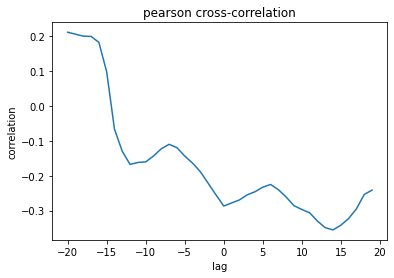

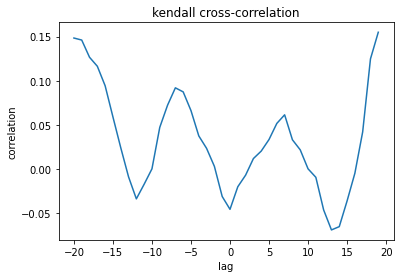

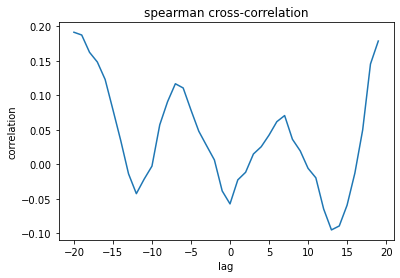

In [10]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("kendall cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("spearman cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

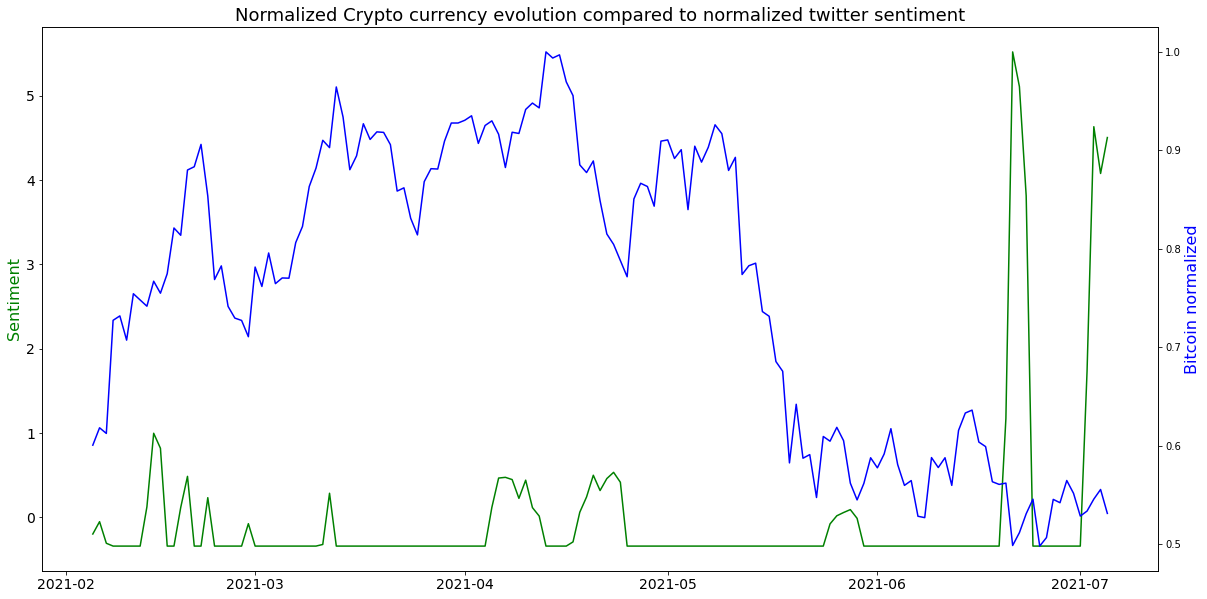

In [11]:
# Normalize time series data
min_max_scaler = preprocessing.StandardScaler()
score_scaled = min_max_scaler.fit_transform(tweets_grouped['compound_sentiment_score'].values.reshape(-1,1))
tweets_grouped['normalized_score'] = score_scaled
# crypto_used_grouped_scaled = min_max_scaler.fit_transform(crypto_usd_grouped.values.reshape(-1,1))
crypto_used_grouped_scaled = crypto_usd_grouped / max(crypto_usd_grouped.max(), abs(crypto_usd_grouped.min()))
# crypto_usd_grouped['normalized_price'] = crypto_used_grouped_scaled

fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Normalized Crypto currency evolution compared to normalized twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped['normalized_score'], 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_used_grouped_scaled, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel("Bitcoin normalized", color='b', fontsize=16)
plt.show()

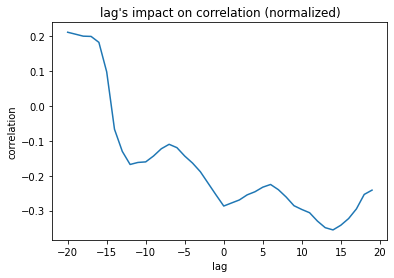

In [12]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i) for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("lag's impact on correlation (normalized)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

In [13]:
# Derivative
tweets_grouped_derivative = pd.Series(np.gradient(tweets_grouped['normalized_score'].values), tweets_grouped.index, name='slope')
crypto_usd_grouped_derivative = pd.Series(np.gradient(crypto_usd_grouped.values), crypto_usd_grouped.index, name='slope')

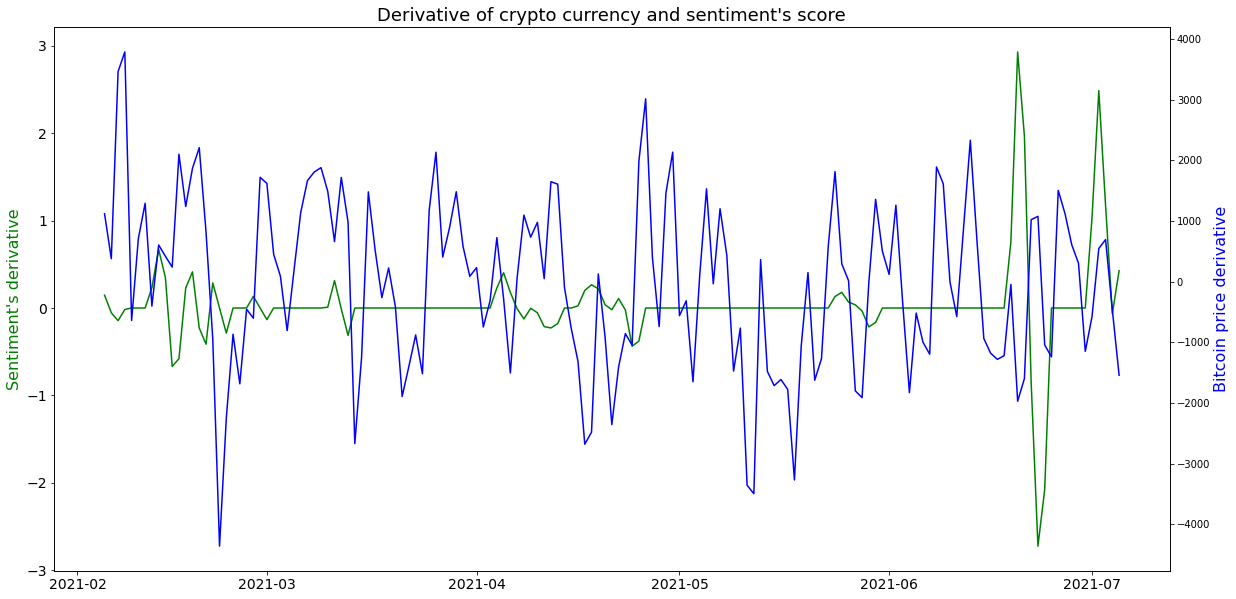

In [14]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Derivative of crypto currency and sentiment's score", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped_derivative.index, tweets_grouped_derivative, 'g-')
ax2.plot_date(crypto_usd_grouped_derivative.index, crypto_usd_grouped_derivative, 'b-')

ax1.set_ylabel("Sentiment's derivative", color='g', fontsize=16)
ax2.set_ylabel('Bitcoin price derivative', color='b', fontsize=16)
plt.show()

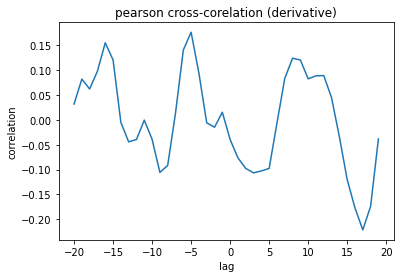

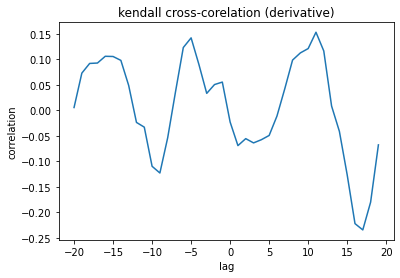

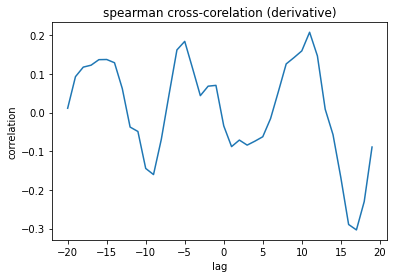

In [15]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped_derivative, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped_derivative, lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("kendall cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped_derivative, lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("spearman cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()